This is a sample lab to explore the concepts in Andrew Ng's Machine Learning course on Coursera

The data set is [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from UCI. It maps thirteen continuous variables representing chemical contents of a wine to three labels, each a different winery in Italy.

Thanks to https://crsmithdev.com/blog/ml-logistic-regression/ for the original source code

## Data preview

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import label_binarize

In [222]:
df = pd.read_csv('data.txt')

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
class                   178 non-null int64
alcohol                 178 non-null float64
malic_acid              178 non-null float64
ash                     178 non-null float64
alcalinity              178 non-null float64
magnesium               178 non-null int64
total_phenols           178 non-null float64
flavanoids              178 non-null float64
nonflavanoid_phenols    178 non-null float64
proanthocyanins         178 non-null float64
color                   178 non-null float64
hue                     178 non-null float64
od                      178 non-null float64
proline                 178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [224]:
df['class'].unique()

array([1, 2, 3])

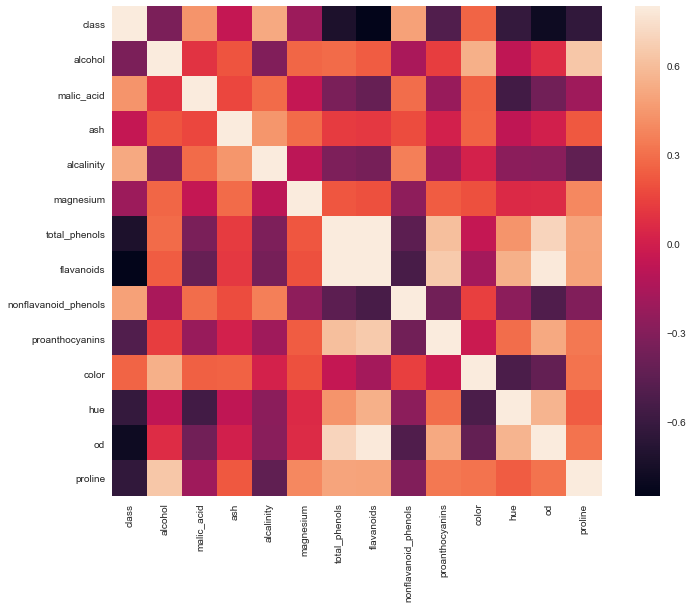

In [225]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

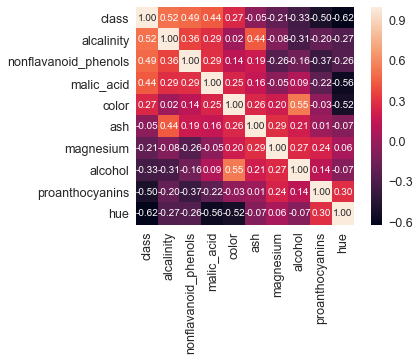

In [226]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'class')['class'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [227]:
df.columns

Index(['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color', 'hue', 'od', 'proline'],
      dtype='object')

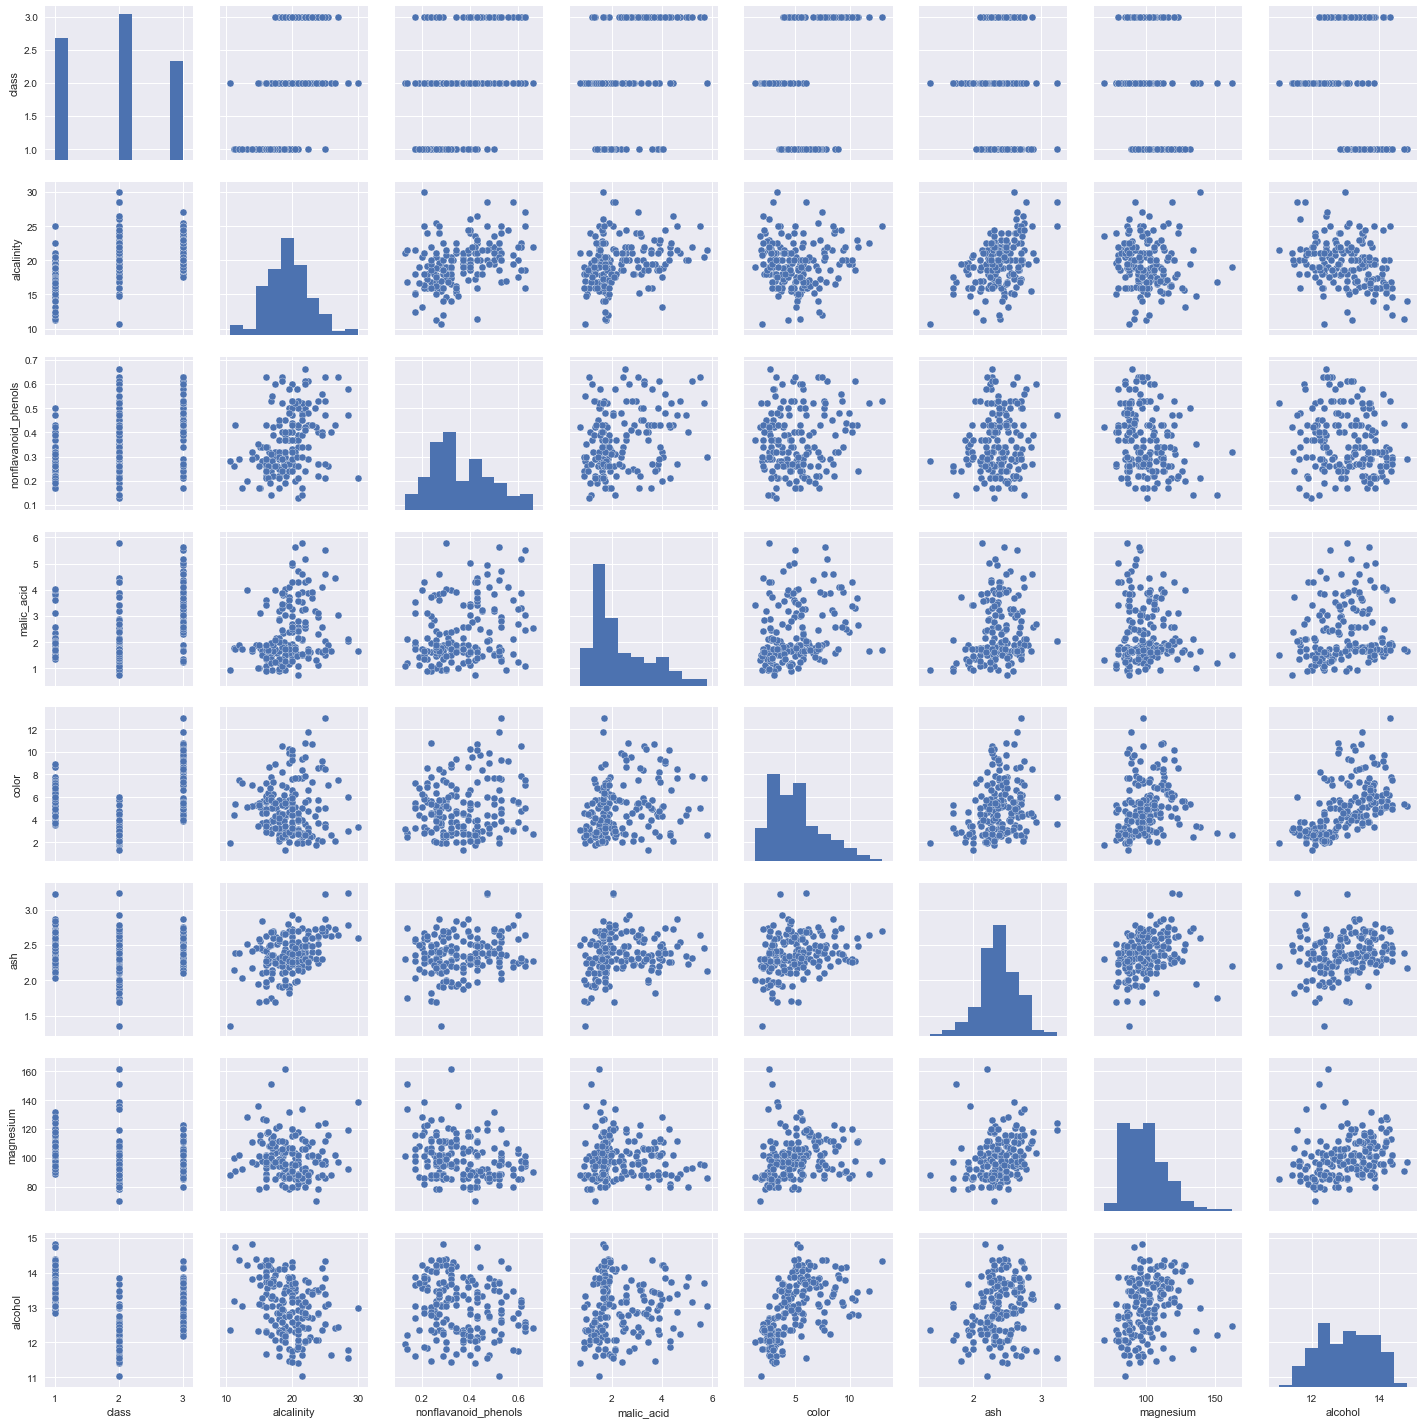

In [228]:
sns.set()
cols = ['class', 'alcalinity', 'nonflavanoid_phenols', 'malic_acid', 'color', 'ash', 'magnesium', 'alcohol']
sns.pairplot(df[cols], size = 2.5)
plt.show();

## Two Classes

In [229]:
df = pd.read_csv('data.txt')
feature_columns = ['alcohol', 'ash']

reduced = df[df['class'] <= 2]
X = reduced.as_matrix(columns=feature_columns)
y = label_binarize(reduced['class'].values, [1, 2])[:,0]

In [230]:
MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

In [231]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('train:', len(X_train), 'test:', len(X_test))

train: 97 test: 33


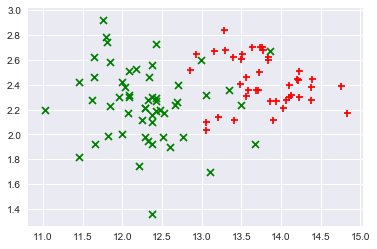

In [232]:
plot_points(X_train, y_train)

## Cost Function

In logistic regression, $h_\theta$ is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  The sigmoid function is bounded between 0 and 1, and produces a value that can be interpreted as a probability.  This value can also be a yes / no answer with a cross-over, or decision boundary, at 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ -\theta^Tx}}
$$

Using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) from linear regression isn't a good idea here, as the resulting cost function [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html) and so is not well-suited for gradient descent.  Instead, the difference of $h_\theta(x^i) - y^i$ is calculated differently for $y=0$ and $y=1$, and the result is [transformed](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarithmically](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) into a convex function: 

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Fortunately, the [derivative](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) of this function is exactly the same as that of linear regression, just with a different $h_\theta(x)$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [233]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

## Train the model

Instead of manually writing a gradient descent, here we use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of 1s to the training data (allowing for a bias parameter $\theta_0$), run the minimization function and return the first of its return values, final parameters for $\theta$.

In [234]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [63.05644953 -4.27673827 -2.95139723]


# Decision Boundaries and Evaluation

In [235]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')

In [236]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.9696969696969697
precision: 0.9705882352941176
recall: 0.9705882352941176


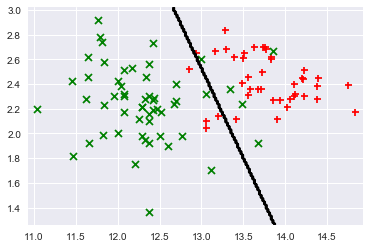

In [237]:
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))

In [238]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       1.00      0.94      0.97        17
          1       0.94      1.00      0.97        16

avg / total       0.97      0.97      0.97        33



In [239]:
def logistic_model_2c(features):
    reduced = df[df['class'] <= 2]
    X = reduced.as_matrix(columns=features)
    y = label_binarize(reduced['class'].values, [1, 2])[:,0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    print('train:', len(X_train), 'test:', len(X_test))
    theta = train(X_train, y_train)
    print('theta: ', theta)
    
    predictions = predict(X_test, theta)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))
    
    plot_points(X_train, y_train)
    plot_boundary(X_train, lambda x: predict(x, theta))

In [240]:
df.columns

Index(['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color', 'hue', 'od', 'proline'],
      dtype='object')

train: 97 test: 33
theta:  [91.68326285 -6.31108062 -3.99516533]
accuracy: 0.8787878787878788
precision: 0.8786764705882353
recall: 0.8786764705882353


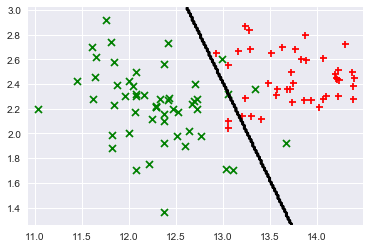

In [241]:
logistic_model_2c(['alcohol', 'ash'])

train: 97 test: 33
theta:  [-8.93254541  3.67571471  0.43982975]
accuracy: 0.696969696969697
precision: 0.7055555555555556
recall: 0.7086466165413534


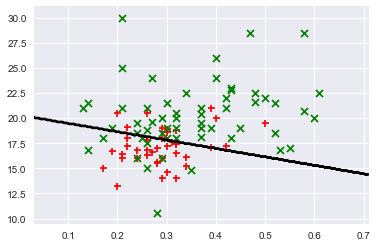

In [242]:
logistic_model_2c(['nonflavanoid_phenols', 'alcalinity'])

train: 97 test: 33
theta:  [-7.4188304  -0.72561398  0.49548229]
accuracy: 0.6666666666666666
precision: 0.6729323308270676
recall: 0.6691176470588236


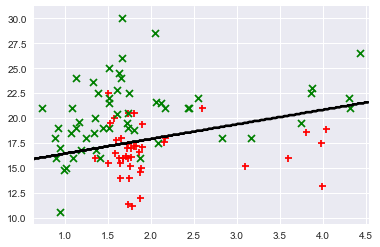

In [243]:
logistic_model_2c(['malic_acid', 'alcalinity'])

## Sklearn

In [244]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [249]:
predictions = logmodel.predict(X_test)

In [246]:
print(logmodel.intercept_) 
print(logmodel.coef_)

[2.33932233]
[[-0.26448614  0.54028931]]


In [247]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.86      0.35      0.50        17
          1       0.58      0.94      0.71        16

avg / total       0.72      0.64      0.60        33



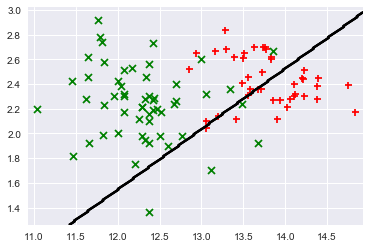

In [248]:
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, [2.33932233, -0.26448614, 0.5402893]))

## Multiple Classes

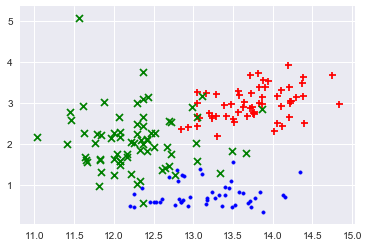

In [250]:
feature_columns = ['alcohol', 'flavanoids']
X = df.as_matrix(columns=feature_columns)
y = df.as_matrix(columns=['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = label_binarize(y_train, [1, 2, 3])
y_all = label_binarize(y, [1, 2, 3])

plot_points(X, y_all.argmax(axis=1))

In [251]:
thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
thetas

[array([-68.97197677,   4.58799896,   3.24410108]),
 array([53.6638232 , -4.39695929,  1.32284268]),
 array([-35.41914474,   3.40756158,  -6.95263965])]

accuracy: 0.9333333333333333
precision: 0.9565217391304347
recall: 0.923076923076923


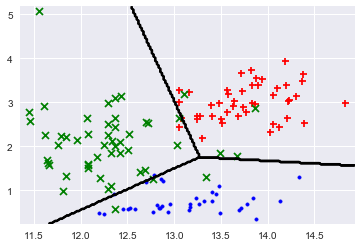

In [252]:
def predict_multi(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(x, thetas))

In [253]:
def logistic_model_3c(features):
    X = df.as_matrix(columns=features)
    y = df.as_matrix(columns=['class'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    y_train = label_binarize(y_train, [1, 2, 3])
    
    thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
    predictions = predict_multi(X_test, thetas) + 1

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_points(X_train, y_train.argmax(axis=1))
    plot_boundary(X_train, lambda x: predict_multi(x, thetas))

accuracy: 0.9555555555555556
precision: 0.9537037037037037
recall: 0.9606481481481483


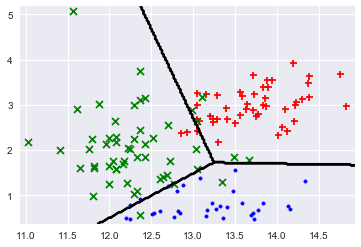

In [254]:
logistic_model_3c(['alcohol', 'flavanoids'])

accuracy: 0.5333333333333333
precision: 0.5386243386243386
recall: 0.5703703703703703


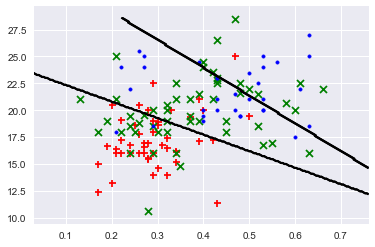

In [255]:
logistic_model_3c(['nonflavanoid_phenols', 'alcalinity'])

accuracy: 0.6222222222222222
precision: 0.6479925303454716
recall: 0.6351294903926483


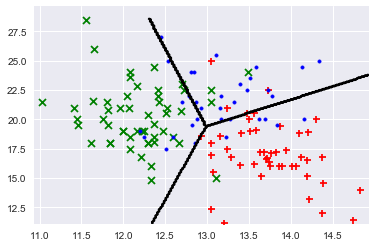

In [256]:
logistic_model_3c(['alcohol', 'alcalinity'])

In [257]:
df.columns

Index(['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color', 'hue', 'od', 'proline'],
      dtype='object')

In [258]:
def transform_x(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1]]

def transform_x_3(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1], x[0] * (x[1] ** 2), x[1] * (x[0] ** 2), x[0] ** 3, x[1] ** 3]


def transform(X):
    return np.apply_along_axis(transform_x, 1, X)

def transform_3(X):
    return np.apply_along_axis(transform_x_3, 1, X)


def polynomial_logistic_model_3c1(features):
    
    X = df.as_matrix(columns=features)
    y = df.as_matrix(columns=['class'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    y_train = label_binarize(y_train, [1, 2, 3])
    
    X_train = transform(X_train)
    X_test = transform(X_test)

    thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
    predictions = predict_multi(X_test, thetas) + 1

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_points(X_train, y_train.argmax(axis=1))
    plot_boundary(X_train, lambda x: predict_multi(transform(x), thetas))
    
def polynomial_logistic_model_3c2(features):
    
    X = df.as_matrix(columns=features)
    y = df.as_matrix(columns=['class'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    y_train = label_binarize(y_train, [1, 2, 3])
    
    X_train = transform_3(X_train)
    X_test = transform_3(X_test)

    thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
    predictions = predict_multi(X_test, thetas) + 1

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_points(X_train, y_train.argmax(axis=1))
    plot_boundary(X_train, lambda x: predict_multi(transform(x), thetas))

accuracy: 0.9111111111111111
precision: 0.9093567251461989
recall: 0.9232456140350878


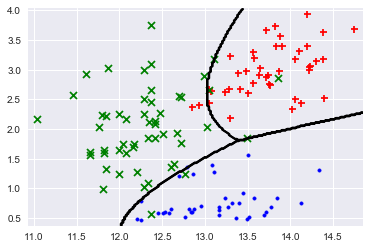

In [263]:
polynomial_logistic_model_3c1(['alcohol', 'flavanoids'])

accuracy: 0.5555555555555556
precision: 0.5412280701754386
recall: 0.5185185185185185


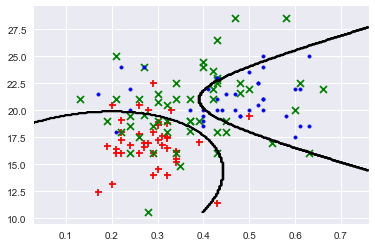

In [264]:
polynomial_logistic_model_3c1(['nonflavanoid_phenols', 'alcalinity'])

# Logistic Regression with TensorFlow

In this last section, I implement logistic regression using TensorFlow and test the model using the same data set. TensorFlow allows for a significantly more compact and higher-level representation of the problem as a computational graph, resulting in less code and faster development of models.

One item definitely worth calling out is the use of the AdamOptimizer instead of the GradientDescentOptimizer from the previous post. Although the latter can still be used here, I found it a poor fit for two reasons: it is very sensitive to learning rate and lambda parameters, and it converges extremely slowly. Correct convergence required a very low learning rate (around 0.001 at most), and could still be seen decreasing at over 300,000 iterations, with a curve that appeared linear after the first thousand. Poor tuning resulted in the optimizer spinning out of control and emitting nan values for all the parameters.

Using a different optimizer helped tremendously, especially one that is adaptive. It converges significantly faster and requires much less hand-holding to do so. Even then, these graphs take typically 25x the time to converge properly compared to the manual implementation above, and I'm not sure why this is the case. Since Tensorflow does the calculus itself to find the gradient, it could be that this is the result of some issue or lack of optimization. On the other hand, given that the platform is designed to distribute computations and scale to significantly larger data sets, this could be some overhead that is quite reasonable in those scenarios but is felt heavily in a small demonstration with a tiny number of examples.

I also adjusted all placeholders and variables to tf.float64, to avoid any issues with numerical precision. After this and the adaptive optimizer, the results improved dramatically.

Because I want to build a few different graphs, I define a function that builds one given a few parameters: the number of features, the number of labels, and a lambda value for regularization. This function tf_create builds a graph, and returns two functions itself: one to train the algorithm by running the optimizer, and another to predict labels for new values. To compute the loss for regularization, I use the built-in tf.nn.l2_loss function, which is equivalent to the regularization loss I computed manually before.

In [265]:
import tensorflow as tf

def tf_create(n_features, n_labels, lambda_):
    
    examples = tf.placeholder(tf.float64, [None, n_features])
    labels = tf.placeholder(tf.float64, [None, n_labels])
    weights = tf.Variable(tf.zeros([n_features, n_labels], dtype=tf.float64))
    bias = tf.Variable(tf.zeros([n_labels], dtype=tf.float64))
    
    hyp = tf.sigmoid(tf.matmul(examples, weights) + bias)
    loss = tf.reduce_mean(-labels * tf.log(hyp) - (1 - labels) * tf.log(1 - hyp))
    reg = lambda_ * tf.nn.l2_loss(weights)
    cost = loss + reg
    
    train = tf.train.AdamOptimizer().minimize(cost)
    predict = tf.argmax(hyp, axis=1)
    
    def train_(sess, X, y, iterations):
        for i in range(iterations):
            sess.run(train, feed_dict={examples: X, labels: y})
            
    def predict_(sess, X):
        return sess.run(predict, feed_dict={examples: X})
    
    return train_, predict_

First, I evaluate the model against the 2-feature, 3-label example from above.

accuracy: 0.9111111111111111
precision: 0.9095117845117845
recall: 0.9196969696969698


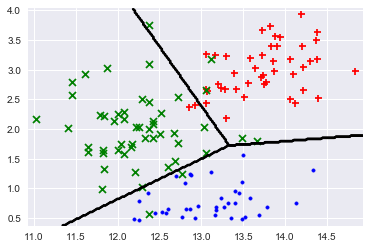

In [267]:
X = df.as_matrix(columns=['alcohol', 'flavanoids'])
y = label_binarize(df['class'], [1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with tf.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.0)
    sess.run(tf.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_boundary(X_train, lambda x: predict(sess, x))
    plot_points(X_train, y_train.argmax(axis=1))

Next, I use the `transform` function to apply additional polynomial features to the dataset, allowing for a non-linear decision boundary.

accuracy: 0.9333333333333333
precision: 0.9375
recall: 0.9545454545454546


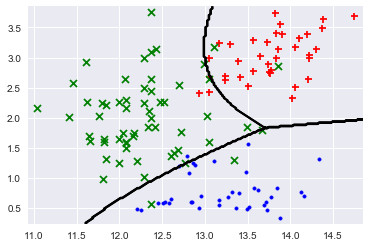

In [268]:
X = df.as_matrix(columns=['alcohol', 'flavanoids'])
X = transform(X)
y = label_binarize(df['class'], [1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with tf.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.0000)
    sess.run(tf.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

    plot_boundary(X_train, lambda x: predict(sess, transform(x)))
    plot_points(X_train, y_train.argmax(axis=1))

Finally, I include all the features from the data set, all the labels, and apply a small amount of regularization.

In [271]:
X = df.drop('class', 1).as_matrix()
y = label_binarize(df['class'], [1, 2, 3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

with tf.Session() as sess:
    
    train, predict = tf_create(X.shape[1], y.shape[1], 0.1)
    sess.run(tf.global_variables_initializer())
    train(sess, X_train, y_train, 30000)

    predictions = predict(sess, X_test)
    y_test = y_test.argmax(axis=1)

    print('accuracy:', accuracy_score(y_test, predictions))
    print('precision:', precision_score(y_test, predictions, average='macro'))
    print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.9333333333333333
precision: 0.9444444444444445
recall: 0.9388888888888888
